In [12]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
#warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data = pd.read_csv("./10feature_cpu.csv")
col = list(map(str, data.columns))
x = data[col[:-1]]
y = data[col[-1]]

scaler = MinMaxScaler()
#dscaler = scaler.fit(x)
#x = dscaler.transform(x)
#y = y.to_numpy()
x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
#test_data_size = 40
#x_train, x_test = x[:-test_data_size], x[-test_data_size:]
#y_train, y_test = y[:-test_data_size], y[-test_data_size:]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=0.5)

model = LGBMRegressor(objective='regression', num_iterations=10**5)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
val_pred = model.predict(x_val)
score = rmse_expm1(val_pred, y_val)
score



Found `num_iterations` in params. Will use it instead of argument


-0.23011074515146546

In [20]:
def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def evaluate(x_data, y_data):
    model = LGBMRegressor(objective='regression', num_iterations=10**5)
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
    val_pred = model.predict(x_val)
    score = rmse_expm1(val_pred, y_val)
    return score

def rfe(x_data, y_data, method, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict(x_val)
        score = rmse_expm1(val_pred, y_val)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
            #print(feat_imp)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    print(feat_imp)
    return archive

feats = [col for col in data.columns if col != 'fault']
len(feats)

10

In [21]:
%%time
basic_archive = rfe(x, y, 'basic')
#print('a')
#print(basic_archive)
#basic_archive.shape

10 -0.14000216630382373
node_memory_Active_anon_bytes           224
node_schedstat_running_seconds_total    216
node_cpu_seconds_total                  215
node_memory_MemFree_bytes               175
node_schedstat_waiting_seconds_total    172
node_schedstat_timeslices_total         171
node_procs_running                      109
process_cpu_seconds_total                98
node_cpu_scaling_frequency_hertz         97
node_memory_Unevictable_bytes             1
dtype: int32
CPU times: user 18.2 s, sys: 348 ms, total: 18.6 s
Wall time: 865 ms


In [8]:
feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp.iloc[:i].index], data['fault']))

40 -0.1423266546202688
45 -0.1423266546202688
50 -0.1423266546202688
55 -0.1423266546202688
60 -0.1423266546202688
65 -0.1423266546202688
70 -0.1423266546202688
75 -0.1423266546202688
80 -0.1423266546202688
85 -0.1423266546202688


In [9]:
%%time
perm_archive = rfe(x, y, 'perm')

10 -0.14000216630382373
node_cpu_seconds_total                  0.637519
node_schedstat_running_seconds_total    0.262010
node_schedstat_waiting_seconds_total    0.036054
node_cpu_scaling_frequency_hertz        0.013930
process_cpu_seconds_total               0.011729
node_memory_MemFree_bytes               0.006071
node_schedstat_timeslices_total         0.001164
node_memory_Active_anon_bytes          -0.000023
node_memory_Unevictable_bytes          -0.000112
node_procs_running                     -0.000722
dtype: float64
CPU times: user 10.9 s, sys: 92 ms, total: 11 s
Wall time: 503 ms


In [10]:
perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
#eli5.show_weights(perm)
eli5.show_weights(perm, top = 40, feature_names = x_train.columns.tolist())

Weight,Feature
0.5284 ± 0.0422,node_schedstat_running_seconds_total
0.4290 ± 0.0291,node_cpu_seconds_total
0.0282 ± 0.0094,node_cpu_scaling_frequency_hertz
0.0204 ± 0.0102,node_schedstat_waiting_seconds_total
0.0131 ± 0.0081,node_memory_MemFree_bytes
0.0103 ± 0.0049,process_cpu_seconds_total
0.0051 ± 0.0044,node_memory_Active_anon_bytes
0.0043 ± 0.0013,node_schedstat_timeslices_total
0.0001 ± 0.0002,node_memory_Unevictable_bytes
-0.0022 ± 0.0032,node_procs_running


In [11]:
for i in range(40, 90, 5):
    print(i, evaluate(data[perm_feat_imp.iloc[:i].index], data['fault']))

Found `num_iterations` in params. Will use it instead of argument


40 -0.14214891753456094
45 -0.14214891753456094
50 -0.14214891753456094
55 -0.14214891753456094
60 -0.14214891753456094
65 -0.14214891753456094
70 -0.14214891753456094
75 -0.14214891753456094
80 -0.14214891753456094
85 -0.14214891753456094


In [22]:
%%time
shap_archive = rfe(x, y, 'shap')

10 -0.14000216630382373
node_cpu_seconds_total                  0.245587
node_schedstat_running_seconds_total    0.137951
node_schedstat_waiting_seconds_total    0.029532
node_cpu_scaling_frequency_hertz        0.015549
process_cpu_seconds_total               0.012673
node_memory_MemFree_bytes               0.011321
node_memory_Active_anon_bytes           0.009598
node_schedstat_timeslices_total         0.007377
node_procs_running                      0.002749
node_memory_Unevictable_bytes           0.000324
dtype: float64
CPU times: user 26.7 s, sys: 520 ms, total: 27.2 s
Wall time: 1.34 s


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


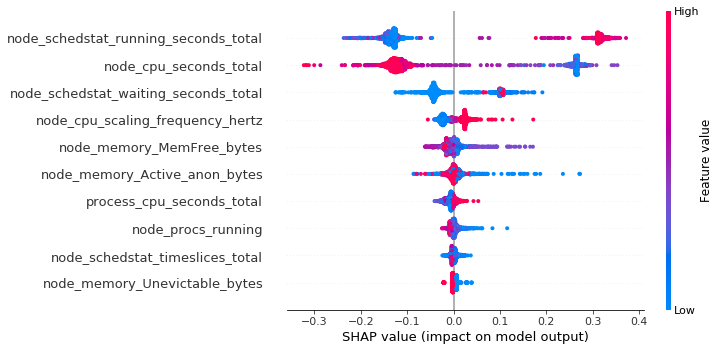

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
shap.summary_plot(shap_values, x)

In [14]:
for i in range(40, 90, 5):
    print(i, evaluate(data[shap_feat_imp.iloc[:i].index], data['fault']))

40 -0.14214891753456094
45 -0.14214891753456094
50 -0.14214891753456094
55 -0.14214891753456094
60 -0.14214891753456094
65 -0.14214891753456094
70 -0.14214891753456094
75 -0.14214891753456094
80 -0.14214891753456094
85 -0.14214891753456094


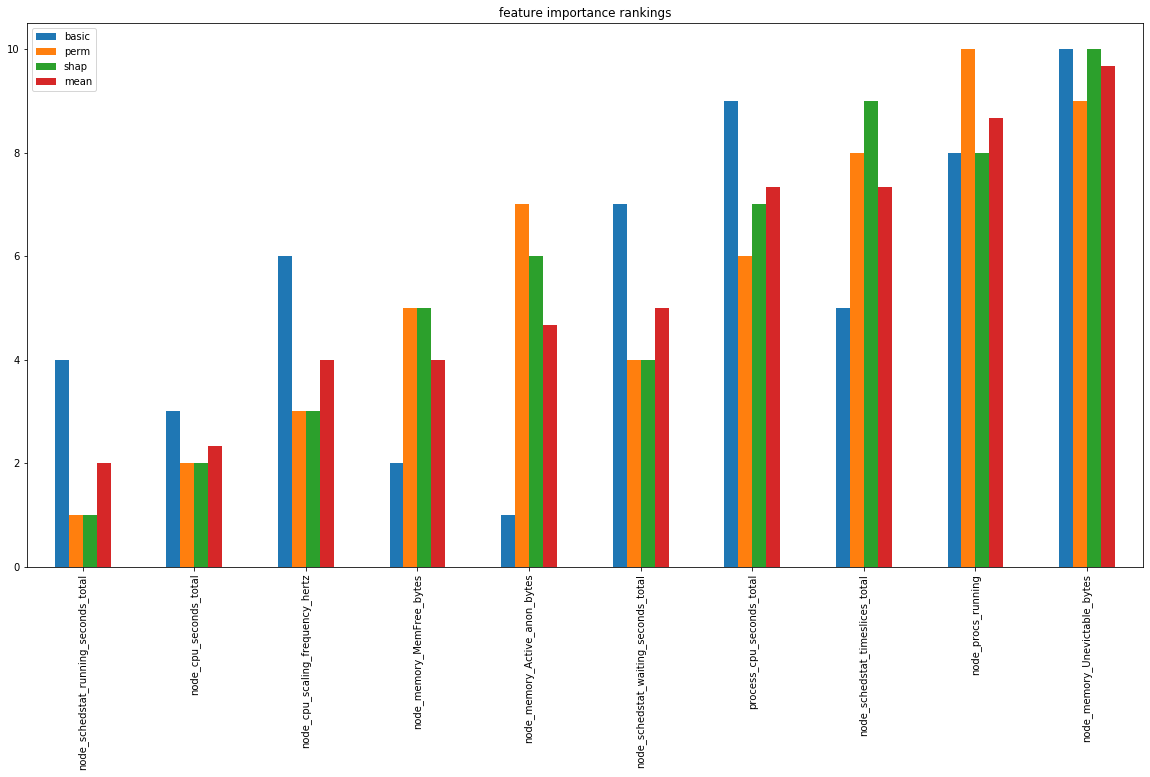

In [15]:
feat_imp_archive = pd.DataFrame(index=feats, columns=['basic', 'perm', 'shap', 'mean'])
feat_imp_archive['basic'] = feat_imp.rank(ascending=False)
feat_imp_archive['perm'] = perm_feat_imp.rank(ascending=False)
feat_imp_archive['shap'] = shap_feat_imp.rank(ascending=False)
feat_imp_archive['mean'] = feat_imp_archive[['basic', 'perm', 'shap']].mean(axis=1)
feat_imp_archive = feat_imp_archive.sort_values('mean')
feat_imp_archive[feat_imp_archive['mean']<20].plot(kind='bar', figsize=(20, 10), title='feature importance rankings');

In [16]:
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp_archive.iloc[:i].index], data['fault']))

Found `num_iterations` in params. Will use it instead of argument


40 -0.14214891753456094
45 -0.14214891753456094
50 -0.14214891753456094
55 -0.14214891753456094
60 -0.14214891753456094
65 -0.14214891753456094
70 -0.14214891753456094
75 -0.14214891753456094
80 -0.14214891753456094
85 -0.14214891753456094


In [17]:
%%time
rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=0)
feat_selector.fit(data[feats].values, data['fault'].values)

evaluate(data[np.array(feats)[feat_selector.support_]], data['fault'])

Found `num_iterations` in params. Will use it instead of argument


CPU times: user 1min 19s, sys: 6.56 s, total: 1min 25s
Wall time: 35.2 s


-0.14649081677125042